In [1]:
import os
import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from xarrayMannKendall import Mann_Kendall_test

warnings.simplefilter('ignore')

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

%matplotlib inline

## Analysis Parameters

In [2]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'
crs='EPSG:4326'

## Open datasets

In [3]:
pku = xr.open_dataarray(f'{base}/NDVI_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc')
pku = pku.rename('NDVI')
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

gimmsv2 = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/GIMMS3g_v1.2_1982_2022.nc')
gimmsv2.attrs['nodata'] = np.nan
# gimmsv2 = assign_crs(xr.open_dataset(base+'NDVI_harmonization/AVHRR_GIMMS3g_v1.2_1982_2022.nc4'), crs='EPSG:4326')
# gimmsv2 = gimmsv2['ndvi']
# gimmsv2 = gimmsv2/10000
# gimmsv2 = gimmsv2.where(gimmsv2>0)
# gimmsv2 = gimmsv2.sel(lat=slice(-10,-45), lon=slice(110,154))
# gimmsv2 = gimmsv2.rename({'lat':'latitude','lon':'longitude'})
# gimmsv2 = assign_crs(gimmsv2, crs='EPSG:4326')
# gimmsv2 = gimmsv2.resample(time='MS', loffset=pd.Timedelta(14, 'd')).median()

ds = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc')['AusENDVI_clim_MCD43A4']
ds = assign_crs(ds, crs='EPSG:4326')
ds = ds.rename('NDVI')
ds.attrs['nodata'] = np.nan
# ds = ds.sel(time=slice('2000','2022'))

syn = assign_crs(xr.open_dataset(base+'/synthetic/NDVI/NDVI_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI'], crs='EPSG:4326')


## Harmonise

In [4]:
ds = ds.odc.reproject(pku.odc.geobox, resampling='average')
syn = syn.odc.reproject(pku.odc.geobox, resampling='average')
gimmsv2 = gimmsv2.odc.reproject(pku.odc.geobox, resampling='nearest')

ds = round_coords(ds)
gimmsv2 = round_coords(gimmsv2)
pku = round_coords(pku)
syn = round_coords(syn)
# ls = round_coords(ls)

#gapfill PKU the same as our product
obs_monthly = pku.groupby('time.month').mean()
obs_anom = pku.groupby('time.month') - obs_monthly
obs_anom = obs_anom.interpolate_na(dim='time', method='linear', limit=1)
pku = obs_anom.groupby('time.month') + obs_monthly
pku = pku.drop('month')
pku = pku.fillna(syn.sel(time=pku.time))

#gimms v1.2
gimms_v2_clim = gimmsv2.groupby('time.month').mean()
gimmsv2 = gimmsv2.fillna(gimms_v2_clim).drop_vars(['month', 'spatial_ref']).isel(month=1)


## Mask

In [5]:
# nan mask
mask = ~np.isnan(ds.mean('time'))

ds = ds.where(mask)
gimmsv2 = gimmsv2.where(mask)
pku = pku.where(mask)

#low NDVI mask
mean_ndvi = ds.mean('time')
low_ndvi_mask = xr.where(mean_ndvi<0.11, 0, 1)

ds = ds.where(low_ndvi_mask)
gimmsv2 = gimmsv2.where(low_ndvi_mask)
pku = pku.where(low_ndvi_mask)

## Annual means

In [6]:
gimmsv2 = gimmsv2.resample(time='YS').mean()
ds = ds.resample(time='YS').mean()
pku = pku.resample(time='YS').mean()

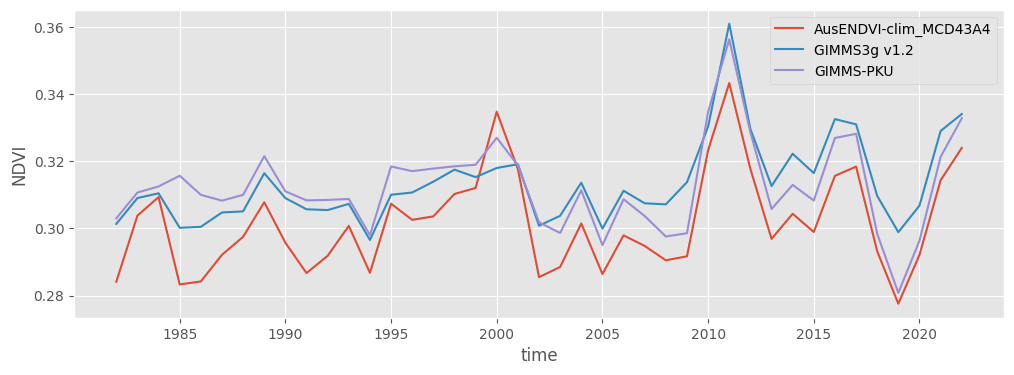

In [7]:
with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,1, figsize=(12,4))
    ds.mean(['latitude','longitude']).plot(ax=ax, label='AusENDVI-clim_MCD43A4')
    gimmsv2.mean(['latitude','longitude']).plot(ax=ax, label='GIMMS3g v1.2')
    pku.mean(['latitude','longitude']).plot(ax=ax, label='GIMMS-PKU')
    ax.legend()
    plt.title(None);

## Per pixel trends


### 1982-2022

In [8]:
ds_trends = Mann_Kendall_test(ds.sel(time=slice('1982','2022')),
                               alpha=0.05, method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

# pku_trends = Mann_Kendall_test(pku.sel(time=slice('1982','2022')),
#                                alpha=0.05, method='theilslopes',
#                                coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

# gimmsv2_trends = Mann_Kendall_test(gimmsv2.sel(time=slice('1982','2022')),
#                                alpha=0.05, method='theilslopes',
#                                coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

### 1982-2001

In [9]:
ds_trends_early = Mann_Kendall_test(ds.sel(time=slice('1982','2001')),
                               alpha=0.05, method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

# pku_trends_early = Mann_Kendall_test(pku.sel(time=slice('1982','2001')),
#                                alpha=0.05, method='theilslopes',
#                                coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

# gimmsv2_trends_early = Mann_Kendall_test(gimmsv2.sel(time=slice('1982','2001')),
#                                alpha=0.05, method='theilslopes',
#                                coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

### 2002-2022

In [10]:
ds_trends_late = Mann_Kendall_test(ds.sel(time=slice('2002','2022')),
                               alpha=0.05, method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

# pku_trends_late = Mann_Kendall_test(pku.sel(time=slice('2002','2022')),
#                                alpha=0.05, method='theilslopes',
#                                coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

# gimmsv2_trends_late = Mann_Kendall_test(gimmsv2.sel(time=slice('2002','2022')),
#                                alpha=0.05, method='theilslopes',
#                                coords_name={'time':'time','x':'longitude','y':'latitude'}).compute()

### Plot per pixel

In [ ]:
_data = [ds_trends, gimmsv2_trends, pku_trends,
        ds_trends_early, gimmsv2_trends_early, pku_trends_early,
        ds_trends_late, gimmsv2_trends_late, pku_trends_late
        ]

products=[
    'AusENDVI-clim_MCD43A4 1982-2022','GIMMS3gv1.2 1982-2022','GIMMS-PKU 1982-2022',
    'AusENDVI-clim_MCD43A4 1982-2001','GIMMS3gv1.2 1982-2001','GIMMS-PKU 1982-2001',
    'AusENDVI-clim_MCD43A4 2002-2022','GIMMS3gv1.2 2002-2022','GIMMS-PKU 2002-2022'
]
m = mask.rename({'longitude':'x','latitude':'y'})

fig,axes = plt.subplots(3,3, figsize=(19,18), sharey=True, sharex=True, layout='constrained')
for ax, dss, n in zip(axes.ravel(), _data, products):
    cmap='BrBG'#'BrBG'
    vmin=-0.004
    vmax=0.004
    
    im = dss.trend.where(m).plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)       
    # cbar = plt.colorbar(im, ax=ax, shrink=0.5)
    # cbar.ax.set_title('NDVI\n yr\u207B\u00B9', fontsize=8)
    # cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    #significane plotting (very slow)
    lons, lats = np.meshgrid(dss.x, dss.y)
    sig_area = np.where(dss.signif == 1)
    ax.hexbin(x=lons[sig_area].reshape(-1),
             y=lats[sig_area].reshape(-1),
             C=dss.signif.where(dss.signif == 1).data[sig_area].reshape(-1),
             hatch='XXXX',
             alpha=0,
             gridsize=(400,400)
            )
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

cb = fig.colorbar(im, ax=axes, shrink=0.40, orientation='horizontal') #label='NDVI yr\u207B\u00B9'
cb.ax.set_title('NDVI yr\u207B\u00B9', fontsize=12)
cb.ax.tick_params(labelsize=12)
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/Annual_average_perpixel_trends.png',
            bbox_inches='tight', dpi=300)

## Trends across environmental gradients

In [11]:
mi = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/MI_1982_2022.nc')
mi = mi.mean('time')
mi = assign_crs(mi, crs='EPSG:4326')
mi = mi.odc.reproject(ds.odc.geobox, resampling='average')
mi = round_coords(mi)
mi = mi.rename('P:PET')
mi = xr.where(mi>3, np.nan, mi) #remove extreme values
# mi = mi.resample(time='YE').mean().mean('time')

trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = trees.mean('time')
trees = assign_crs(trees, crs='EPSG:4326')
trees = trees.odc.reproject(ds.odc.geobox, resampling='average')
trees = round_coords(trees)

grass = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/grass_5km_monthly_1982_2022.nc')['grass']
grass = grass.mean('time')
grass = assign_crs(grass, crs='EPSG:4326')
grass = grass.odc.reproject(ds.odc.geobox, resampling='average')
grass = round_coords(grass)

## mask crops

In [12]:
ag = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/AusENDVI/data/5km/Landcover_5km_monthly_1982_2022.nc').isel(time=0),
                crs='epsg:4326')
ag = xr.where(ag==40,1,0)
ag = ag.odc.reproject(ds.odc.geobox, resampling='mode')
ag = round_coords(ag)
ag = ~ag.astype(bool)

ds_trends = ds_trends.where(ag.rename({'latitude':'y', 'longitude':'x'}))
ds_trends_early = ds_trends_early.where(ag.rename({'latitude':'y', 'longitude':'x'}))
ds_trends_late = ds_trends_late.where(ag.rename({'latitude':'y', 'longitude':'x'}))

trees = trees.where(ag)
grass = grass.where(ag)
mi = mi.where(ag)

In [14]:
m = mask.rename({'longitude':'x','latitude':'y'})
ds_trends_df = ds_trends.trend.where(m).to_dataframe().drop(['spatial_ref', 'time'], axis=1)
ds_trends_early_df = ds_trends_early.trend.where(m).to_dataframe().drop(['spatial_ref', 'time'], axis=1)
ds_trends_late_df = ds_trends_late.trend.where(m).to_dataframe().drop(['spatial_ref', 'time'], axis=1)

trees_df = trees.to_dataframe(name='trees').drop(['spatial_ref', 'time'], axis=1)
grass_df = grass.to_dataframe(name='grass').drop(['spatial_ref', 'time'], axis=1)
mi_df = mi.to_dataframe(name='P:PET').drop(['spatial_ref', 'time'], axis=1)

In [15]:
ds_trends_df = ds_trends_df.rename({'trend':'NDVI Trend 1982-2022'}, axis=1)
ds_trends_df['NDVI Trend 1982-2001'] = ds_trends_early_df
ds_trends_df['NDVI Trend 2002-2022'] = ds_trends_late_df
ds_trends_df['Tree Fraction'] = trees_df
ds_trends_df['Grass Fraction'] = grass_df
ds_trends_df['P:PET'] = mi_df

In [16]:
df = ds_trends_df.dropna()

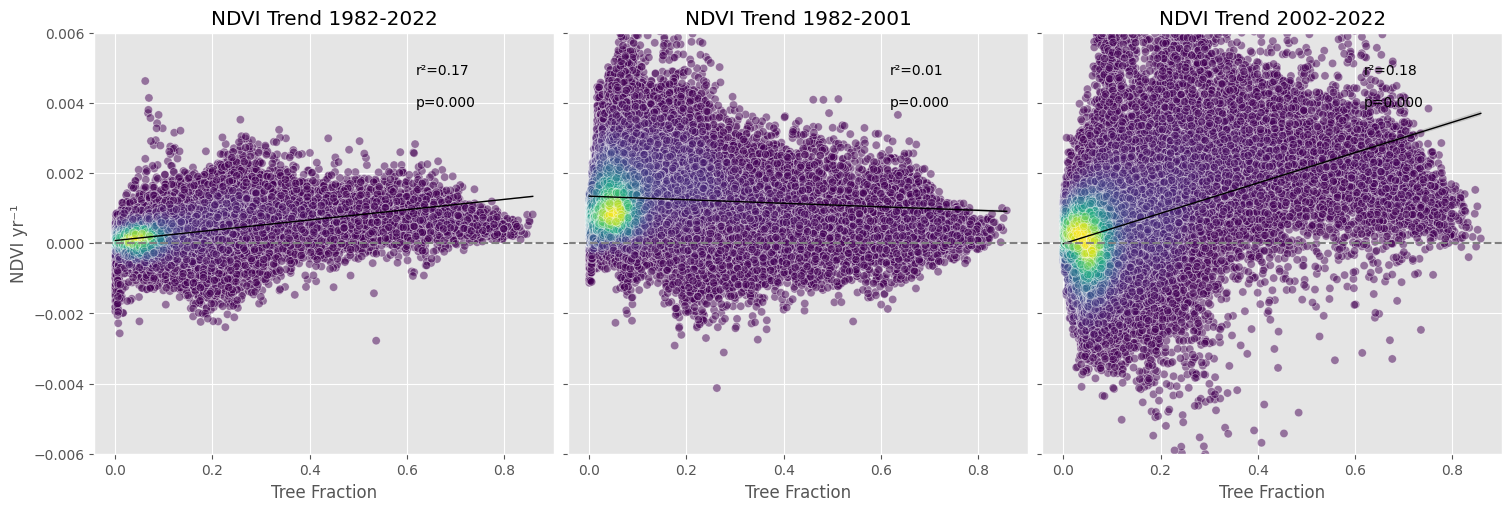

In [18]:
# var='P:PET'
var='Tree Fraction'

with plt.style.context('ggplot'):
    fig,axes=plt.subplots(1,3, figsize=(15,5),  layout='constrained', sharey=True, sharex=True)

    for ax,t in zip(axes.ravel(), ['NDVI Trend 1982-2022', 'NDVI Trend 1982-2001', 'NDVI Trend 2002-2022']): 
    
        obs,pred = df[var].values, df[t].values
        mask = ~np.isnan(obs) & ~np.isnan(pred)
        sl, i, r, p, s = stats.linregress(obs,pred)
        r2 = r**2
    
        xy = np.vstack([obs[mask],pred[mask]])
        z = gaussian_kde(xy)(xy)
        
        sb.scatterplot(data=df, x=var,y=t, alpha=0.5, ax=ax, c=z)
        sb.regplot(data=df, x=var,y=t, scatter=False,
                   line_kws={'linewidth':1}, color='black', ax=ax)
        ax.set_ylim(-0.006, 0.006)
        ax.set_title(t)
        ax.set_ylabel('NDVI yr⁻¹')
        ax.axhline(0, color='grey', linestyle='--')
        ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
                transform=ax.transAxes, fontsize=10)
        ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=10)

## Model Causal drivers per pixel

Use iterative linear modelling

### Relationship between environmental gradients and CO2 sensitivity

In [71]:
mi = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/MI_1982_2022.nc')
mi = mi.mean('time')
mi = assign_crs(mi, crs='EPSG:4326')
mi = mi.rename('P:PET')
mi = xr.where(mi>3, np.nan, mi) #remove extreme values

In [75]:
results={}
for index,row in significant.iterrows():

    #mask the wcf and mi datasets
    geom = Geometry(geom=row.geometry, crs=significant.crs)
    moist = mi.odc.mask(poly=geom)
    moist = moist.mean(['latitude','longitude']).values.item()

    results[row.SUB_NAME_7] = moist

results = pd.Series(results,name='P:PET')
significant = significant.join(results, on='SUB_NAME_7')

Text(0.7, 0.825, 'p=0.000')

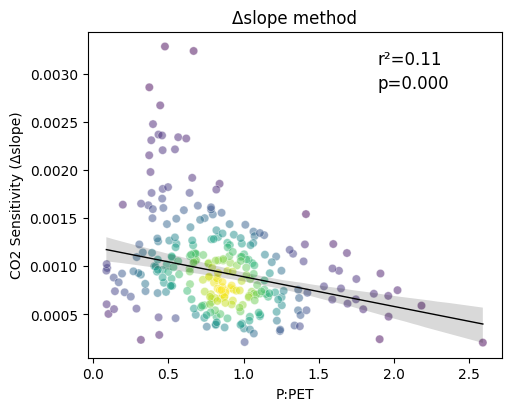

In [80]:
fig,ax=plt.subplots(1,1, figsize=(5,4),  layout='constrained', sharey=True, sharex=True)

obs,pred = significant['P:PET'].values, significant['slope_difference'].values
mask = ~np.isnan(obs) & ~np.isnan(pred)
sl, i, r, p, s = stats.linregress(obs,pred)
r2 = r**2

xy = np.vstack([obs[mask],pred[mask]])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=significant, x='P:PET',y='slope_difference', alpha=0.5, ax=ax, c=z)
sb.regplot(data=significant, x='P:PET',y='slope_difference',  scatter=False,
           line_kws={'linewidth':1}, color='black', ax=ax, robust=True)
# ax.set_ylim(-0.006, 0.006)
ax.set_title(u'Δslope'+' method')
ax.set_ylabel('CO2 Sensitivity ('+u'Δslope'+')')
# ax.axhline(0, color='grey', linestyle='--')
ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
        transform=ax.transAxes, fontsize=12)
ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12)